# Task 4 - Bot Detection

In [82]:
# General:
import os               # To get auth from environmant variables
import tweepy           # To consume Twitter's API
import pandas as pd     # To handle data
import numpy as np      # For number computing
import datetime as dt
import time
import re
import botometer


#Libraybry for Stream
from tweepy import Stream
from tweepy.streaming import StreamListener
#Library for json to transfer crawled data to a dictionary to get access easier
from tweepy.utils import import_simplejson
json = import_simplejson()
#Library for spliting and evaluating
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# For plotting and visualization:
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline


In [227]:
#Get consumer key, consumer secret, access token, access secret from Enviroment Variable to get authentication
def get_twitter_auth():
    try:
        # Key:
        CONSUMER_KEY    = os.environ.get('CONSUMER_KEY')
        CONSUMER_SECRET = os.environ.get('CONSUMER_SECRET')
        # Access:
        ACCESS_TOKEN  = os.environ.get('ACCESS_TOKEN')
        ACCESS_SECRET = os.environ.get('ACCESS_SECRET')
    except KeyError:
        sys.stderr.write("TWITTER_* Environment variables of Twitter authentication has not set\n")
        sys.exit(1)
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
    return auth

## Collecting Data
- Data includes: 1000 twitter's account and 100 tweets / account
- Some method to crawl data:
 - Get twitter's account:
     - From all tweets we crawl by Streaming (Save to file userlist.csv)
     - From dataset we collect on the Internet (Save to file userlist1.csv)
 - Get 100 tweets: User tweepy API to get tweets from the timeline by screen name 

In [3]:
#Input the maximum number of tweet crawled
limit = int(input("The maximum number of twitter accounts: "))
#Create listener to get crawled tweets
class listener(StreamListener):
    def __init__(self):
        self.num_acc = 0
        self.user = np.empty(0)
        self.text = np.empty(0)
    def on_data(self, raw_data, limit = limit):
        #Stop when get enough tweets
        if (self.num_acc < limit):
            #Tansfer raw_data to get the value easier
            data = json.loads(raw_data)
            #Sleep to avoid IncompleteRead Error
            #if self.num_acc % 500 == 0: time.sleep(2)
            #Ensure data is a tweet and its language is english
            if ('created_at' in data.keys() and data['lang'] == 'en'):
                scrname = data['user']['screen_name']
                self.user = np.append(self.user, scrname)
                self.num_acc += 1
                print (self.num_acc)
            return True
        else:
            print (len(self.user))
            print (self.user)
            df = pd.DataFrame({"User":self.user})
            #All users retrieved from crawled tweets are saved to csv file
            df.to_csv('userlist.csv', index = False)
            return False

The maximum number of twitter accounts: 20000


In [228]:
#Get tweepy API
auth = get_twitter_auth()
extractor = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [ ]:
#Use stream to crawl random tweets
twitterStream = Stream(extractor.auth, listener())
twitterStream.filter(track=['the','i','a', 'you', 'me', 'am', 'are', 'is', 'not', 'what', 'they', 'he', 'she', 'it'], async = True)

In [223]:
#userlist1.csv is a dataset a get on the Internet
main_file_path = 'userlist1.csv'
df = pd.read_csv(main_file_path, encoding = 'ISO-8859-1')
df = df.sample(frac=1).reset_index(drop=True)
users = np.array(df['User'])
bot_label = np.array(df['Bot'])
#user_uni = np.unique(users)

___Note:___
   - Previous codes indicate 2 ways to get list of users
   - I will use the result of the second way to save to the (The first way request us to create bot label, which can be done by __botometer API__. However, labeling process takes a lot of time)

## Bonus: Botometer API
- Description: check whether a user is a bot and which kinds of bot a user belongs to

In [181]:
import botometer
def bot_api():
    twitter_app_auth = {
        'consumer_key' : os.environ.get('CONSUMER_KEY'),
        'consumer_secret' : os.environ.get('CONSUMER_SECRET'),
        'access_token' : os.environ.get('ACCESS_TOKEN'),
        'access_secret' : os.environ.get('ACCESS_SECRET'),
    }
    return botometer.Botometer(wait_on_ratelimit = True, mashape_key = "IdvfOq9Wkfmsh5g3fxZfn3Eun0eYp1NHDV7jsnTMcAYvfvAbjY", **twitter_app_auth)
bot = bot_api()
result = bot.check_account(users[12])
print (result)

{'cap': {'english': 0.0026183131920431966, 'universal': 0.0027296301902785666}, 'categories': {'content': 0.15849545789507336, 'friend': 0.11264701462189411, 'network': 0.15895834190828398, 'sentiment': 0.23941479464567658, 'temporal': 0.21842691073303097, 'user': 0.027817972609638725}, 'display_scores': {'content': 0.8, 'english': 0.4, 'friend': 0.6, 'network': 0.8, 'sentiment': 1.2, 'temporal': 1.1, 'universal': 0.3, 'user': 0.1}, 'scores': {'english': 0.07343326191269153, 'universal': 0.06078011352084069}, 'user': {'id_str': '28871546', 'screen_name': 'Ginuwine'}}


- Result:
 - Cap: the probability of the event "user is a bot"
  - english: use six categories of features to calculate
  - universal:  omits sentiment and content features
 - categories:  gives subscores for each of the six feature classes
 - display_score: gives the overall and category scores in the 0-to-5 scale
 - user: user's infomation

## Creating features
- Some features we can easily get from an user: number of listed, followers, favorites_count, friends, statuses, verified status, default profile, default profile image
- Some features we can generate from 100 tweets of an user: mean of mentioned user, hashtag, url, retweet, like per tweet
- A bag of words of bot are collected. Checking whether screen name, name, description, status contain those words are also features that we can use

In [230]:
#Count number of mentioned users in a tweet
def count_mention(txt):
    mentioned_users = re.findall(r"@(\w+)", txt)
    return len(mentioned_users)
#Count number of hashtags in a tweet
def count_hashtag(txt):
    hashtags = re.findall(r"#(\w+)", txt)
    return len(hashtags)

def count_url(txt):
    urls = re.findall(r"\w+:\/\/\S+", txt)
    return len(urls)

#Create our features by aggregating over users’ tweets
def create_feature(tweets):
    ment_user_mean = 0
    hashtag_mean = 0
    url_mean = 0
    retweet_mean = 0
    like_mean = 0
    
    for tweet in tweets:
        ment_user_mean += count_mention(tweet.text)
        hashtag_mean += count_hashtag(tweet.text)
        url_mean += count_url(tweet.text)
        retweet_mean += tweet.retweet_count
        like_mean += tweet.favorite_count
    
    return ment_user_mean/100, hashtag_mean/100, url_mean/100, retweet_mean/100, like_mean/100

In [91]:
#Tweets'feature
mention = np.full(1000, 0.)
hashtag = np.full(1000, 0.)
url = np.full(1000, 0.)
retweet = np.full(1000, 0.)
like = np.full(1000, 0.)
#User'features
listed_count = np.full(1000, 0.)
followers_count = np.full(1000, 0.)
favorites_count = np.full(1000, 0.)
friends_count = np.full(1000, 0.)
statuses_count = np.full(1000, 0.)
verified = np.full(1000, 0.)
default_profile = np.full(1000, 0.)
default_profile_image = np.full(1000, 0.)

screen_name = np.empty(0)
name = np.empty(0)
description = np.empty(0)
status = np.empty(0)
bot = np.empty(0)
count = 0

start = time.time()

for i, user in enumerate(users):
    print (count, i)
    if count == 1000:
        break
    try:
        acc = extractor.get_user(user)
        tweets = extractor.user_timeline(screen_name=user, count=130)
    except tweepy.TweepError:
        continue
    if len(tweets) >= 100:
        #Create tweets'feature
        x1, x2, x3,x4, x5 = create_feature(tweets[:100])
        mention[count] = x1
        hashtag[count] = x2
        url[count] = x3
        retweet[count] = x4
        like[count] = x5
        
        #Create user'features
        listed_count[count] = acc.listed_count
        followers_count[count] = acc.followers_count
        favorites_count[count] = acc.favourites_count
        friends_count[count] = acc.friends_count
        statuses_count[count] = acc.statuses_count
        verified[count] = acc.verified
        default_profile[count] =  acc.default_profile
        default_profile_image[count] = acc.default_profile_image
        
        #Get a list to check bag of word 's bot later
        screen_name = np.append(screen_name, acc.screen_name)
        name = np.append(name, acc.name)
        description = np.append(description, acc.description)
        status = np.append(status, acc.status)
        bot = np.append(bot, bot_label[i])
        count += 1
        
    #else:
    #    print (len(tweets))

end = time.time()
print (end -start)

0 0
1 1
1 2
2 3
3 4
3 5
4 6
4 7
5 8
5 9
6 10
7 11
7 12
8 13
9 14
9 15
9 16
10 17
10 18
11 19
11 20
11 21
12 22
12 23
13 24
13 25
14 26
14 27
15 28
16 29
17 30
18 31
18 32
19 33
20 34
21 35
22 36
23 37
24 38
25 39
26 40
27 41
27 42
27 43
28 44
29 45
30 46
31 47
31 48
32 49
32 50
33 51
33 52
34 53
35 54
36 55
36 56
36 57
37 58
37 59
38 60
38 61
39 62
40 63
41 64
42 65
43 66
44 67
45 68
46 69
47 70
48 71
48 72
49 73
50 74
51 75
52 76
53 77
54 78
54 79
55 80
55 81
56 82
56 83
56 84
56 85
56 86
56 87
56 88
56 89
57 90
58 91
59 92
60 93
61 94
62 95
63 96
64 97
65 98
66 99
67 100
68 101
69 102
70 103
71 104
71 105
72 106
72 107
72 108
72 109
73 110
74 111
75 112
76 113
76 114
76 115
77 116
78 117
79 118
80 119
81 120
82 121
82 122
83 123
84 124
84 125
85 126
86 127
87 128
88 129
89 130
89 131
90 132
91 133
92 134
92 135
93 136
94 137
94 138
94 139
95 140
96 141
96 142
97 143
98 144
99 145
99 146
100 147
101 148
102 149
103 150
104 151
105 152
106 153
107 154
108 155
109 156
110 157
111 158
11

787 1052
788 1053
789 1054
790 1055
791 1056
792 1057
793 1058
794 1059
795 1060
796 1061
797 1062
798 1063
799 1064
800 1065
801 1066
802 1067
803 1068
804 1069
805 1070
806 1071
807 1072
807 1073
808 1074
809 1075
809 1076
809 1077
809 1078
810 1079
810 1080
810 1081
810 1082
811 1083
812 1084
812 1085
813 1086
813 1087
814 1088
815 1089
816 1090
817 1091
817 1092
818 1093
819 1094
820 1095
821 1096
821 1097
821 1098
822 1099
823 1100
823 1101
824 1102
825 1103
826 1104
826 1105
827 1106
827 1107
828 1108
829 1109
830 1110
830 1111
831 1112
832 1113
833 1114
834 1115
835 1116
836 1117
837 1118
838 1119
838 1120
839 1121
840 1122
841 1123
842 1124
843 1125
843 1126
844 1127
844 1128
844 1129
845 1130
845 1131
846 1132
847 1133
848 1134
849 1135
850 1136
851 1137
851 1138
852 1139
853 1140
854 1141
854 1142
854 1143
855 1144
855 1145
855 1146
856 1147
857 1148
858 1149
859 1150
859 1151
860 1152
861 1153
861 1154
862 1155
863 1156
863 1157
864 1158
865 1159
866 1160
867 1161
867 1162
8

In [ ]:
df.to_csv('userlist.csv', index = False)
user_test.to_csv('userlist.csv', index = False)

In [106]:
binary_features = ['screen_name_check','name_check','description_check','status_check','Verified','Default profile','Default profile image']
continuous_features = ['Mean User/tweet','Mean Hashtag/tweet','Mean URL/tweet','Mean retweet/tweet','Mean like/tweet','Listed count','Follower count','Favorite count','Friend count','Status count']

## Selecting features
We will use some methods to select features:

#### 1) Correlation Coefficient

In [4]:
main_file_path = 'feature_data.csv'
user_data = pd.read_csv(main_file_path)
user_data

,Bot,Default profile,Default profile image,Favorite count,Follower count,Friend count,Listed count,Mean Hashtag/tweet,Mean URL/tweet,Mean User/tweet,Mean like/tweet,Mean retweet/tweet,Status count,Verified,screen_name_check,name_check,description_check,status_check
0,0.0,0.0,0.0,0.0,73656086.0,99.0,87996.0,0.64,1.08,0.25,116707.08,15385.70,3200.0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,33275.0,9248.0,1536.0,200.0,0.01,0.40,1.25,24.07,124.71,9474.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,175.0,0.0,12.0,0.00,0.00,1.98,0.90,0.11,199.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,29.0,101.0,82.0,0.0,0.50,0.38,0.30,0.01,94.51,6567.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,0.0,79.0,0.0,10.0,0.00,1.00,0.00,0.48,0.44,1261.0,0.0,1.0,1.0,1.0,0.0
5,1.0,1.0,0.0,5106.0,1684.0,0.0,170.0,0.00,1.00,1.00,1.86,0.78,57061.0,0.0,0.0,1.0,1.0,0.0
6,0.0,0.0,0.0,5108.0,501713.0,792.0,4890.0,0.20,0.49,1.59,80.52,469.92,10097.0,1.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,19.0,242379.0,1042.0,1421.0,0.03,0.99,0.14,37.30,15.27,19541.0,1.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,28.0,24019.0,24966.0,721.0,0.77,0.89,0.00,4.26,1.32,1757.0,0.0,0.0,0.0,0.0,0.0
9,1.0,1.0,0.0,0.0,127.0,22.0,7.0,0.00,0.00,0.06,0.08,0.02,4588.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
correlation = user_data.corr(method='spearman')

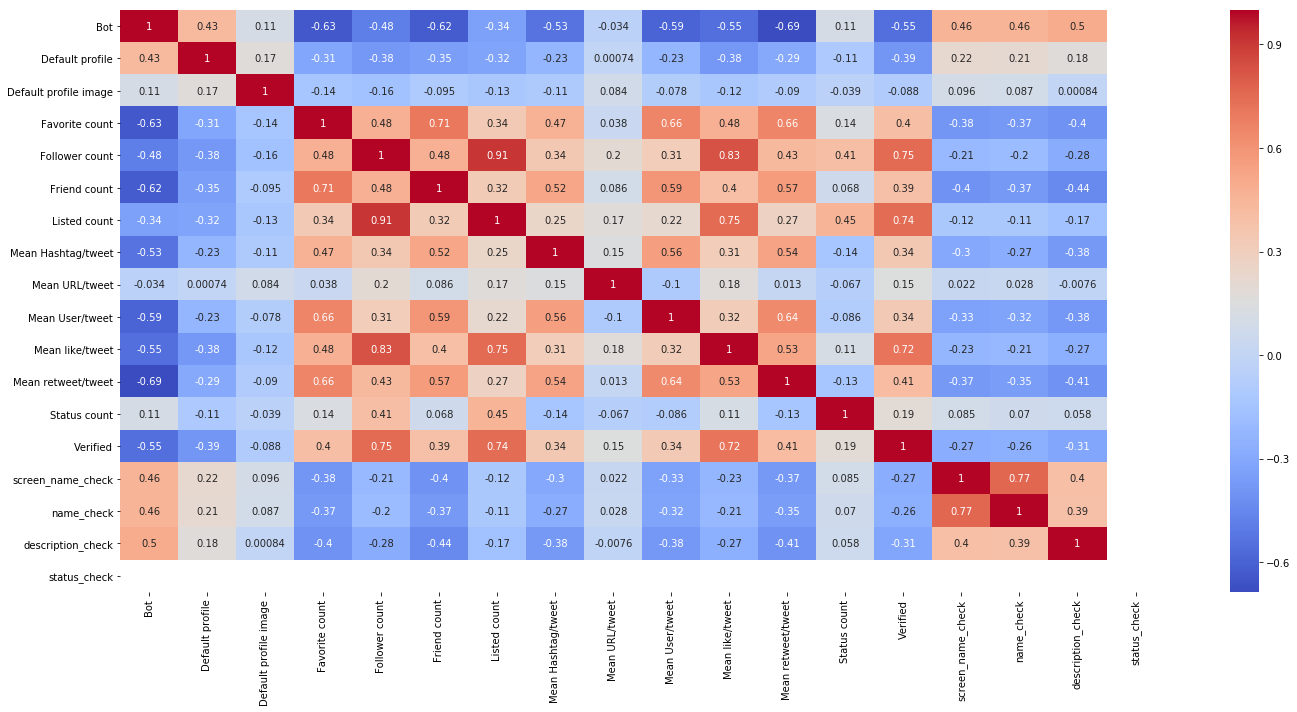

In [102]:
plt.figure(figsize=(20,10))
sns.heatmap(correlation, cmap='coolwarm', annot=True)
plt.tight_layout()
plt.show()

In [149]:
print ("- Feature correlation coefficient with target value:")
print(correlation.iloc[0,1:].sort_values(axis = 0))

- Feature correlation coefficient with target value:
Mean retweet/tweet      -0.685827
Favorite count          -0.634492
Friend count            -0.624122
Mean User/tweet         -0.593034
Mean like/tweet         -0.551645
Verified                -0.548812
Mean Hashtag/tweet      -0.533028
Follower count          -0.484254
Listed count            -0.337896
Mean URL/tweet          -0.034062
Status count             0.107510
Default profile image    0.109688
Default profile          0.425712
name_check               0.455186
screen_name_check        0.458518
description_check        0.499144
status_check                  NaN
Name: Bot, dtype: float64


___Result:___
- Suppose the absolute threshold (which help us decide whether the relation between feature and target is strong enough or not) is 0.4, we can remove these features:
 - Listed count, Mean URL/tweet, Status count, Default profile image, status_check


#### 2) Feature Importance by Extrta trees

In [122]:
#Features and target extraction
X, y = user_data[binary_features + continuous_features], user_data['Bot']

In [107]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesClassifier()
clf = clf.fit(X, y)
print (clf.feature_importances_)
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
X_new.shape 

[0.11413344 0.0652256  0.09470409 0.         0.09881347 0.08232095
 0.00408208 0.16471073 0.04006152 0.07387823 0.06214234 0.03200873
 0.02927878 0.02278584 0.03552856 0.04281715 0.03750849]


(1000, 8)

In [121]:
print ("Number of all features: ", X.shape[1])

print ("Number of selected features: ", X_new.shape[1])

Number of all features:  17
Number of selected features:  8


___Result:___
 - Feature rank: 
  - Mean User/tweet
  - screen_name_check
  - Verified
  - description_check
  - Default profile
  - Mean URL/tweet
  - name_check
  - Mean retweet/tweet
  - Friend count
  - Mean hashtag/tweet
  - Status count
  - Favorite count
  - Mean like/tweet
  - List count
  - Follower count
  - Default profile image
  - status_check

#### 3) Recursive Feature Elimination (RFE)

In [208]:
# Feature Extraction with RFE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
# feature extraction
model = LogisticRegression()
rfe = RFE(model, 12)
fit = rfe.fit(X, y)
print("Num Features: ", fit.n_features_)
print("Selected Features: ", fit.support_)
print("Feature Ranking: ", fit.ranking_)


Num Features:  12
Selected Features:  [ True  True  True False False  True False  True False False  True  True
  True  True  True  True  True]
Feature Ranking:  [1 1 1 6 2 1 4 1 5 3 1 1 1 1 1 1 1]


___Result___:
 - If we choose 12 features, 5 removed features: status_check, Verified, Default profile image, Mean Hashtag/tweet, Mean URL/tweet
 - Feature Rank:
  - Mean like/tweet
  - Listed count
  - Mean retweet/tweet
  - Favorite count
  - Status count
  - Friend count
  - Follower count
  - Mean User/tweet
  - description_check
  - Default profile
  - name_check
  - screen_name_check
  - Verified
  - Mean URL/tweet
  - Mean Hashtag/tweet
  - Default profile image
  - status_check
 - Due to the result, we can see that this method prioritize continuous features. However, small variable is considered as a bad case in this method (for example, Mean hashtag abd mean url/tweet)

### Overall result:
- 3 methods will have their own characteristics, which may badly affect the result
- Due to the result, I will remove some features having bad result in all methods: Default profile image, status_check, Follower count, Status count, Mean URL/tweet
- Some features are put in suspicion: List count, Verified

## Feature preprocessing

- Normalizing all numberic features
- Keep all binary features

In [182]:
#Selected features with suspicion
normalized_features = ['Mean User/tweet','Mean Hashtag/tweet','Mean retweet/tweet','Mean like/tweet','Listed count','Favorite count','Friend count']
nonnormalized_features = ['screen_name_check','name_check','description_check','Verified','Default profile']

## Preprocessing with testing dataset
- Do all previous steps with a testing dataset (including 200 users) to have a testing dataset
- Save to test_data.csv for testing later

In [183]:
from sklearn.preprocessing import normalize
normalized_data = normalize(user_data[normalized_features])
normalized_data = pd.DataFrame(columns = normalized_features, data = normalized_data)

nonnormalized_data = pd.DataFrame(columns = nonnormalized_features, data = user_data[nonnormalized_features])

X = pd.concat([nonnormalized_data, normalized_data], axis=1)
y = user_data['Bot']

In [ ]:
#Crawl 200 users for testing API later

#Tweets'feature
mention1 = np.full(200, 0.)
hashtag1 = np.full(200, 0.)
url1 = np.full(2000, 0.)
retweet1 = np.full(200, 0.)
like1 = np.full(200, 0.)
#User'features
listed_count1 = np.full(200, 0.)
followers_count1 = np.full(200, 0.)
favorites_count1 = np.full(200, 0.)
friends_count1 = np.full(200, 0.)
statuses_count1 = np.full(200, 0.)
verified1 = np.full(200, 0.)
default_profile1 = np.full(200, 0.)
default_profile_image1 = np.full(200, 0.)

screen_name1 = np.empty(0)
name1 = np.empty(0)
description1 = np.empty(0)
status1 = np.empty(0)
bot1 = np.empty(0)
count = 0

start = time.time()

for i, user in enumerate(users[1331:]):
    print (count, 1331 + i)
    if count == 200:
        break
    try:
        acc = extractor.get_user(user)
        tweets = extractor.user_timeline(screen_name=user, count=130)
    except tweepy.TweepError:
        continue
    if len(tweets) >= 100:
        #Create tweets'feature
        x1, x2, x3,x4, x5 = create_feature(tweets[:100])
        mention1[count] = x1
        hashtag1[count] = x2
        url1[count] = x3
        retweet1[count] = x4
        like1[count] = x5
        
        #Create user'features
        listed_count1[count] = acc.listed_count
        followers_count1[count] = acc.followers_count
        favorites_count1[count] = acc.favourites_count
        friends_count1[count] = acc.friends_count
        statuses_count1[count] = acc.statuses_count
        verified1[count] = acc.verified
        default_profile1[count] =  acc.default_profile
        default_profile_image1[count] = acc.default_profile_image
        
        #Get a list to check bag of word 's bot later
        screen_name1 = np.append(screen_name1, acc.screen_name)
        name1 = np.append(name1, acc.name)
        description1 = np.append(description1, acc.description)
        status1 = np.append(status1, acc.status)
        bot1 = np.append(bot1, bot_label[i])
        count += 1
        
    #else:
    #    print (len(tweets))

end = time.time()
print (end -start)

In [244]:
user_test = pd.DataFrame({"Mean User/tweet":mention1, "Mean Hashtag/tweet":hashtag1, "Mean retweet/tweet": retweet1, "Mean like/tweet": like1,
                     "Listed count": listed_count1, "Favorite count": favorites_count1, "Friend count": friends_count1, 
                     "Verified": verified1, "Default profile": default_profile1, "Bot":bot1})

#Check whether screen name, name, description, status contain those bot's bag of words
bag_of_words_bot = r'bot|b0t|cannabis|tweet me|mishear|follow me|updates every|gorilla|yes_ofc|forget' \
                    r'expos|kill|clit|bbb|butt|fuck|XXX|sex|truthe|fake|anony|free|virus|funky|RNA|kuck|jargon' \
                    r'nerd|swag|jack|bang|bonsai|chick|prison|paper|pokem|xx|freak|ffd|dunia|clone|genie|bbb' \
                    r'ffd|onlyman|emoji|joke|troll|droop|free|every|wow|cheese|yeah|bio|magic|wizard|face'

screen_name1 = pd.Series(screen_name1)
name1 = pd.Series(name1)
description1 = pd.Series(description1)
            
user_test['screen_name_check'] = pd.Series(screen_name1.str.contains(bag_of_words_bot, case=False, na=False), dtype = float)
user_test['name_check'] = pd.Series(name1.str.contains(bag_of_words_bot, case=False, na=False), dtype = float)
user_test['description_check'] = pd.Series(description1.str.contains(bag_of_words_bot, case=False, na=False), dtype = float)

SyntaxError: positional argument follows keyword argument (<ipython-input-244-b29a71ea1ad3>, line 8)

In [245]:
normalized_data1 = normalize(user_test[normalized_features])
normalized_data1 = pd.DataFrame(columns = normalized_features, data = normalized_data1)

nonnormalized_data1 = pd.DataFrame(columns = nonnormalized_features, data = user_test[nonnormalized_features])

screen_name1.name='Screen name'
user_test_data = pd.concat([screen_name1, nonnormalized_data1, normalized_data1, user_data['Bot']], axis=1)

In [247]:
user_test_data.to_csv('test_data.csv', index = False)

## Use Random Forest to train

In [187]:
#Split training set to training set and validating set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

In [190]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
 
pipe_line = Pipeline([
            ("clf", RandomForestClassifier(n_estimators = 500, n_jobs = -1, criterion='entropy', min_samples_leaf=100, min_samples_split=20))
        ])



In [261]:
grid

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__n_estimators': [500, 666, 833, 1000], 'clf__min_samples_split': [20, 50], 'clf__min_samples_leaf': [100, 150, 200], 'clf__bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [252]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 500, stop = 1000, num = 4)]
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(40, 120, num = 3)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [20, 50]
# Minimum number of samples required at each leaf node
min_samples_leaf = [100, 150, 200]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'clf__n_estimators': n_estimators,
               'clf__min_samples_split': min_samples_split,
               'clf__min_samples_leaf': min_samples_leaf,
               'clf__bootstrap': bootstrap}
grid = GridSearchCV(pipe_line, param_grid=random_grid, cv=3)

In [253]:
X = user_data[normalized_features + nonnormalized_features]
y = user_data['Bot']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

In [255]:
start = time.time()
grid.fit(X_train, y_train)
end = time.time()
print ("Running time: ",end - start, "s")

Running time:  347.7538869380951 s


In [256]:
grid.best_params_

{'clf__bootstrap': False,
 'clf__min_samples_leaf': 100,
 'clf__min_samples_split': 20,
 'clf__n_estimators': 1000}

In [258]:
y_pred_train = grid.predict(X_train)
y_pred_test = grid.predict(X_test)

print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))
print("Trainig F1 Score: %.5f" %f1_score(y_train, y_pred_train))
print("Test F1 Score: %.5f" %f1_score(y_test, y_pred_test))

Trainig Accuracy: 0.91000
Test Accuracy: 0.88500
Trainig F1 Score: 0.90037
Test F1 Score: 0.86471


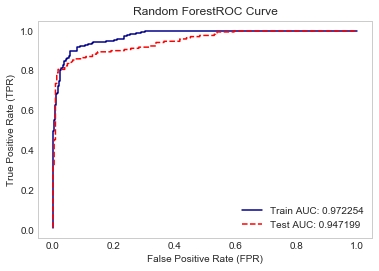

In [257]:
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = grid.predict_proba(X_train)
scores_test = grid.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_rf_train, tpr_rf_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_rf_test, tpr_rf_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_rf_train, tpr_rf_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_rf_train, tpr_rf_train))
plt.plot(fpr_rf_test, tpr_rf_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_rf_test, tpr_rf_test))
plt.title("Random ForestROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

## Create API for this model

- Use pickle library to encode and write API 

In [220]:
import dill as pickle
#Encode model
filename = 'model_v1.pk'
with open(filename, 'wb') as file:
    pickle.dump(grid, file)

In [222]:
#decode and get model
with open(filename ,'rb') as f:
    loaded_model = pickle.load(f)
    
loaded_model.predict(X_test)

array([0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0.,
       0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1.,
       0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 1.